# Naturalistic Analyses

This tutorial will cover features in quail that allow the package to be used to analyze and plot data from naturalistic free recall experiments. 

There are three key word arguments in the `analyze` method particularly useful for naturalistic analysis:
1. `match` - the matching approach used to compute recall matrices
2. `distance` - the distance function used to compare presented and recalled items
3. `features` - which features to consider when computing distance

First, let's load in some example data

In [105]:
import quail
%matplotlib inline
egg = quail.load_example_data(dataset='naturalistic')

This example data is based on an open dataset from Chen et al., 2017, in which 17 participants viewed and then verbally recounted an episode of the BBC series _Sherlock_. We fit a topic model to hand-annotated text descriptions of the video and used the model to transform the video annotations and the recall transcriptions for each subject. We then used a Hidden Markov Model to segment the video and recall models in _k_ events. 

Here, the egg's `pres` field consists of 34 stimulus events (the number of segments determined by our HMM) for each subject. Each stimulus event is represented by a dictionary containing the temporal position of the video segment (`'item'`) and and the array of topic vectors classified as that event (`'features'`).

In [84]:
# The presentation position of each stimulus event...
egg.get_pres_items().head()

,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
1,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
2,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
3,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
4,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33


In [85]:
# ...and their corresponding topic vectors
egg.get_pres_features().head()

,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,"{'features': [1.3095040225638681e-05, 1.309504...","{'features': [1.1307998068474283e-05, 1.130799...","{'features': [9.693039650300355e-06, 9.6930396...","{'features': [9.913957255604304e-06, 9.9139572...","{'features': [1.0626906175571998e-05, 1.062690...","{'features': [1.0663216195539594e-05, 1.066321...","{'features': [1.0532922580253435e-05, 1.053292...","{'features': [1.022682519393662e-05, 1.0226825...","{'features': [9.815446687603108e-06, 9.8154466...","{'features': [9.707331800972813e-06, 9.7073318...",...,"{'features': [1.1240052636101565e-05, 1.124005...","{'features': [1.2320787734091317e-05, 1.232078...","{'features': [1.224700269751644e-05, 1.2247002...","{'features': [1.1916331700340415e-05, 1.191633...","{'features': [1.1204077693770254e-05, 1.120407...","{'features': [1.1367721441462295e-05, 1.136772...","{'features': [1.0987763886778575e-05, 1.098776...","{'features': [1.0659164036611576e-05, 1.065916...","{'features': [1.8863247709037007e-05, 1.886324...","{'features': [0.0001067916639972405, 0.0001067..."
1,0,"{'features': [1.3095040225638681e-05, 1.309504...","{'features': [1.1307998068474283e-05, 1.130799...","{'features': [9.693039650300355e-06, 9.6930396...","{'features': [9.913957255604304e-06, 9.9139572...","{'features': [1.0626906175571998e-05, 1.062690...","{'features': [1.0663216195539594e-05, 1.066321...","{'features': [1.0532922580253435e-05, 1.053292...","{'features': [1.022682519393662e-05, 1.0226825...","{'features': [9.815446687603108e-06, 9.8154466...","{'features': [9.707331800972813e-06, 9.7073318...",...,"{'features': [1.1240052636101565e-05, 1.124005...","{'features': [1.2320787734091317e-05, 1.232078...","{'features': [1.224700269751644e-05, 1.2247002...","{'features': [1.1916331700340415e-05, 1.191633...","{'features': [1.1204077693770254e-05, 1.120407...","{'features': [1.1367721441462295e-05, 1.136772...","{'features': [1.0987763886778575e-05, 1.098776...","{'features': [1.0659164036611576e-05, 1.065916...","{'features': [1.8863247709037007e-05, 1.886324...","{'features': [0.0001067916639972405, 0.0001067..."
2,0,"{'features': [1.3095040225638681e-05, 1.309504...","{'features': [1.1307998068474283e-05, 1.130799...","{'features': [9.693039650300355e-06, 9.6930396...","{'features': [9.913957255604304e-06, 9.9139572...","{'features': [1.0626906175571998e-05, 1.062690...","{'features': [1.0663216195539594e-05, 1.066321...","{'features': [1.0532922580253435e-05, 1.053292...","{'features': [1.022682519393662e-05, 1.0226825...","{'features': [9.815446687603108e-06, 9.8154466...","{'features': [9.707331800972813e-06, 9.7073318...",...,"{'features': [1.1240052636101565e-05, 1.124005...","{'features': [1.2320787734091317e-05, 1.232078...","{'features': [1.224700269751644e-05, 1.2247002...","{'features': [1.1916331700340415e-05, 1.191633...","{'features': [1.1204077693770254e-05, 1.120407...","{'features': [1.1367721441462295e-05, 1.136772...","{'features': [1.0987763886778575e-05, 1.098776...","{'features': [1.0659164036611576e-05, 1.065916...","{'features': [1.8863247709037007e-05, 1.886324...","{'features': [0.0001067916639972405, 0.0001067..."
3,0,"{'features': [1.3095040225638681e-05, 1.309504...","{'features': [1.1307998068474283e-05, 1.130799...","{'features': [9.693039650300355e-06, 9.6930396...","{'features': [9.913957255604304e-06, 9.9139572...","{'features': [1.0626906175571998e-05, 1.062690...","{'features': [1.0663216195539594e-05, 1.066321...","{'features': [1.0532922580253435e-05, 1.053292...","{'features': [1.022682519393662e-05, 1.0226825...","{'features': [9.815446687603108e-06, 9.8154466...","{'features': [9.707331800972813e-06, 9.7073318...",...,"{'features': [1.1240052636101565e-05, 1.124005...","{'features': [1.2320787734091317e-05, 1.232078...","{'features': [1.224700269751644e-05, 1.2247002...","{'features': [1.1916331700340415e-05, 1.191633...","{'features': [1.1204077693770

The `rec` field contains the recall events segmented by the HMM for each subject, represented by the event's temporal posotion in the recall transcription (`'item'`) and topic vectors it comprises (`'features'`).

In [86]:
# The presentation position of each recall event...
egg.get_rec_items().head()

,,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,3,4,5,6,7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,2,3,4,5,6,7,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,2,3,4,5,6,7,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,1,2,3,4,5,6,7,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,1,2,3,4,5,6,7,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# ...and their corresponding topic vectors
egg.get_rec_features().head()

,,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,"{'features': [0.00019430992385381985, 0.000194...","{'features': [0.00017027929367231326, 0.000170...","{'features': [0.00017369078885231097, 0.000173...","{'features': [0.00019384831708918682, 0.000193...","{'features': [0.00021172689406944874, 0.000211...","{'features': [0.0001967417938833908, 0.0001967...","{'features': [0.00018739098716436903, 0.000187...","{'features': [0.0007029745321813258, 0.0007029...",{},{},...,{},{},{},{},{},{},{},{},{},{}
1,0,"{'features': [0.0001893882261801681, 0.0001893...","{'features': [0.000147870701282558, 0.00014787...","{'features': [0.00019023353033654396, 0.000190...","{'features': [0.00018166938444643692, 0.000181...","{'features': [0.0001625481095703973, 0.0001625...","{'features': [0.00017324045166665215, 0.000173...","{'features': [0.00020984959154624308, 0.000209...","{'features': [0.00021871502948704968, 0.000218...","{'features': [0.00023880652209349367, 0.000238...","{'features': [0.00020811361546785266, 0.000208...",...,{},{},{},{},{},{},{},{},{},{}
2,0,"{'features': [0.00018590937074552605, 0.000185...","{'features': [0.0002086223458447991, 0.0002086...","{'features': [0.00014376082951536893, 0.000143...","{'features': [0.00017953275349176222, 0.000179...","{'features': [0.0001266373016964342, 0.0001266...","{'features': [0.00012300799059941801, 0.000123...","{'features': [0.00012981062271781097, 0.000129...","{'features': [0.00013602953297943621, 0.000136...","{'features': [0.00014111281486418062, 0.000141...","{'features': [0.00012592147339385905, 0.000125...",...,{},{},{},{},{},{},{},{},{},{}
3,0,"{'features': [0.00018228403991448364, 0.000182...","{'features': [0.00018629081950116504, 0.000186...","{'features': [0.0001622345358076629, 0.0001622...","{'features': [0.00023810735183527187, 0.000238...","{'features': [0.0001552297878347715, 0.0001552...","{'features': [0.00016179442394432278, 0.000161...","{'features': [0.00016889623308560304, 0.000168...","{'features': [0.00019056297121315633, 0.000190...","{'features': [0.0005565476190479086, 0.0005565...",{},...,{},{},{},{},{},{},{},{},{},{}
4,0,"{'features': [0.00025446487845416085, 0.000254...","{'features': [0.00027871701312132265, 0.000278...","{'features': [0.00023918073796144946, 0.000239...","{'features': [0.00017315740792590048, 0.000173...","{'features': [0.0001356024754279286, 0.0001356...","{'features': [9.160956058842264e-05, 9.1609560...","{'features': [9.360224876174755e-05, 9.3602248...","{'features': [0.00013752072250850062, 0.000137...","{'features': [0.0001320162835250347, 0.0001320...","{'features': [0.00014302384767721986, 0.000143...",...,{},{},{},{},{},{},{},{},{},{}


# The `match` key word argument

The `match` kwarg in `egg.analyze` sets the approach for matching a recall event to its corresponding stimulus event.
There are three options: `'exact'`, `'best'`, and `'smooth'`. 

If `match='exact'`, the recall item must be identical to the stimulus to constitute a recall. This is the traditional approach for free recall experiments (either a person recalled the stimulus word, or did not) but it is not particularly useful with naturalistic data.

If `match='best'`, the 

In [113]:
spc = egg.analyze(analysis='spc', match='best', distance='correlation', features=['features'])

KeyError: 'features'

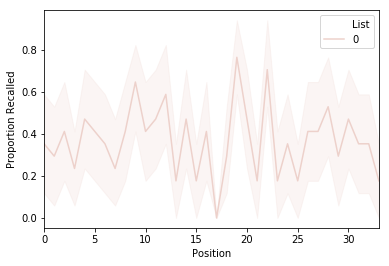

In [75]:
spc.plot()

In [5]:
import numpy as np
from scipy.spatial.distance import cdist

In [70]:
video_events = np.load('/Users/paxtonfitzpatrick/Downloads/video_event_model.npy')
recall_events = np.load('/Users/paxtonfitzpatrick/Downloads/recall_event_models.npy')

In [7]:
# pres = [[[{'item' : i, 'features' : m} for i, m in enumerate(video_events)]] for sub in range(17)]

# rec = []
# for r in recall_events:
#     items = list(np.argmax(1 - cdist(video_events, r), 0).astype(int))
#     rec.append([[{'item' : item, 'features' : t} for item, t in zip(items, r)]])

In [71]:
pres = [[[{'features' : m} for i, m in enumerate(video_events)]] for sub in range(17)]

rec = []
for r in recall_events:
    items = list(np.argmax(1 - cdist(video_events, r), 0).astype(int))
    rec.append([[{'features' : t} for item, t in zip(items, r)]])

In [72]:
andyegg = quail.Egg(pres=pres, rec=rec)
andyegg.info()

Number of subjects: 17
Number of lists per subject: 1
Number of words per list: 34
Date created: Tue Aug  7 13:01:37 2018
Meta data: {}


In [82]:
andyegg.save('../../quail/data/naturalistic.egg')

In [109]:
andyegg.rec.head()[0][0].values

array([{'features': array([0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.03059039, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.0069705 , 0.05237379, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.15410529, 0.07533432,
       0.00019431, 0.00019431, 0.06742324, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.06648943,
       0.00019431, 0.03302216, 0.00019431, 0.12266544, 0.00019431,
       0.00019431, 0.00019431, 0.05083721, 0.00019431, 0.00019431,
       0.02276291, 0.04937134, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.08240707, 0.00019431,
       0.00019431, 0.00019431, 0.04695012, 0.00019431, 0.04930335,
       0.00019431, 0.00019431, 0.00019431,

In [110]:
egg.rec.head()[0][0].values

array([{'features': array([0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.03059039, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.0069705 , 0.05237379, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.15410529, 0.07533432,
       0.00019431, 0.00019431, 0.06742324, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.00019431, 0.06648943,
       0.00019431, 0.03302216, 0.00019431, 0.12266544, 0.00019431,
       0.00019431, 0.00019431, 0.05083721, 0.00019431, 0.00019431,
       0.02276291, 0.04937134, 0.00019431, 0.00019431, 0.00019431,
       0.00019431, 0.00019431, 0.00019431, 0.08240707, 0.00019431,
       0.00019431, 0.00019431, 0.04695012, 0.00019431, 0.04930335,
       0.00019431, 0.00019431, 0.00019431,

In [104]:
for li, l in enumerate(lists):
    p_list = egg.pres.loc[l]
    r_list = egg.pres.loc[l]
    for i, feature in enumerate(egg.feature_names):
        get_feature = lambda x: np.array(x[feature]) if x['item'] is not np.nan else np.nan

        p = np.vstack(p_list.apply(get_feature).get_values())
        r = r_list.dropna().apply(get_feature).get_values()

[[1.30950402e-05 1.30950402e-05 1.30950402e-05 ... 1.30950402e-05
  1.30950402e-05 1.30950402e-05]
 [1.13079981e-05 1.13079981e-05 1.13079981e-05 ... 1.13079981e-05
  1.13079981e-05 1.13079981e-05]
 [9.69303965e-06 9.69303965e-06 9.69303965e-06 ... 9.69303965e-06
  9.69303965e-06 9.69303965e-06]
 ...
 [1.06591640e-05 1.06591640e-05 1.06591640e-05 ... 6.17495448e-01
  1.06591640e-05 1.06591640e-05]
 [1.88632477e-05 1.88632477e-05 1.88632477e-05 ... 9.96753061e-01
  1.88632477e-05 1.88632477e-05]
 [1.06791664e-04 1.06791664e-04 1.06791664e-04 ... 9.89427625e-01
  1.06791664e-04 1.06791664e-04]]
[array([1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 6.98128585e-02,
       1.30950402e-05, 1.30950402e-05, 1.309

[array([1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 6.98128585e-02,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
       1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
     

In [ ]:
lists = presented.index.get_values()
    res = np.empty((len(lists), len(features), recalled.iloc[0].shape[0], presented.iloc[0].shape[0]))*np.nan
    for li, l in enumerate(lists):
        p_list = presented.loc[l]
        r_list = recalled.loc[l]
        for i, feature in enumerate(features):
            get_feature = lambda x: np.array(x[feature]) if x['item'] is not np.nan else np.nan

In [60]:
from quail.analysis.recmat import _similarity_smooth

In [68]:
#_similarity_smooth(egg.pres, egg.rec, egg.feature_names, egg.dist_funcs)

In [69]:
#_similarity_smooth(andyegg.pres, andyegg.rec, andyegg.feature_names, andyegg.dist_funcs)

{'features': 'euclidean', 'temporal': 'euclidean'}